In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
from scipy.stats import pearsonr

from brian2 import *
from brian2tools import *


import matplotlib.style as style
style.use('seaborn-v0_8-colorblind')

/home/patricia/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


# 1. Neuron and Synapse model

**1.1 Neuron model**

In this tutorial we will use a Leaky-Integrate and Fire (LIF) neuron. The mathematical definition of the LIF is the following:

\begin{align*}
C_m \frac{dv}{dt} = g_l \cdot (E_L - v)+ I_{\eta} \end{align*}

where $C_m$ is the capacitance of the membrane, $g_l$ the leak conductance and $I_{\eta} $ is a noisy current to model the effect of background activity

We implement this model using BRIAN (https://brian2.readthedocs.io/en/stable/). The slider in the following plot allows you to in- and decrease the strength of the noisy background current.


In [2]:
#set neuron parameters
E_l = -79 * mV
v_spike = -49 * mV
C_m = 180*pF
g_l = 18 * nS

I_mu = 0 * pA
#these parameters result in a membrane time constant of 10ms
#contant current needs to be around 540pA to elicit regular spiking behaviour

#neuron equations
LIF_eq_simple = '''dv/dt = (g_l * (E_l - v)+ I_eta)/C_m  : volt (unless refractory)
                dI_eta/dt = 1/ tau_noise * (I_mu - I_eta) + I_sigma*xi*tau_noise**-0.5 : ampere
                I_sigma : ampere
                tau_noise : second'''



#Define the neuron. Syntax: NeuronGroup(number of neurons, differential equation)
# you can also define further properties like method, threshold, reset, refactory
def run_brian_neurons(strength):
    start_scope() #deletes any remaining BRIAN objects
    LIF_neuron = NeuronGroup(1, LIF_eq_simple, threshold = 'v > v_spike', reset = 'v = E_l', refractory = 3 * ms, method = 'euler')
    LIF_neuron.I_sigma = strength * pA
    LIF_neuron.tau_noise = C_m/g_l
    LIF_neuron.v = E_l #need to set the membrane potential to its starting point

    #to record activity we need to define monitors
    record_s = SpikeMonitor(LIF_neuron)
    record_v = StateMonitor(LIF_neuron, ['v','I_eta'], record = True, dt = 1 * ms)

    run(5000 * ms, report = 'text')

    return record_s, record_v


def update_brianplot(noise_sig):

    spikemon, rec_v = run_brian_neurons(noise_sig)

    fig, ax = plt.subplots(2,1,figsize=(6, 6))
    ax[0].plot(rec_v.t, rec_v.I_eta[0]/pA)
    ax[0].grid(True)
    ax[0].set_ylabel('$I_{\eta}[pA]$')
    ax[1].plot(rec_v.t,rec_v.v[0]/mV)
    ax[1].scatter(spikemon.t, spikemon.i - 45, color = 'r') #we set the indicators for the spike a bit above the spike threshold. if you want to plot a spike raster you just use SpikeMonitor.i
    ax[1].set_xlabel('t[s]')
    ax[1].set_ylabel('$v[mV]$')
    ax[0].set_title('LIF Neuron')
    ax[1].grid(True)

    fig.tight_layout()

# Create a slider
slider = widgets.FloatSlider(value=250, min=100, max=500, step=50, description="I_σ [pA]:")

# Use interactive to update the plot when the slider moves
interactive_plot = widgets.interactive_output(update_brianplot, {'noise_sig': slider})

# Display slider and interactive plot
display(slider, interactive_plot)


FloatSlider(value=250.0, description='I_σ [pA]:', max=500.0, min=100.0, step=50.0)

Output()

**1.2 Conductance based synapses**

Conductance-based synapses model the synaptic current depending on the momentary membrane potential. The conductance $g$ increases when a presynaptic spike occurs and relaxes back to its starting value progressively afterwards. The synaptic current $ I^{syn} $ received by a neuron is given by:

\begin{align*} \frac{dg}{dt} &= - \frac{g}{\tau_{syn}} + s \\ I^{syn}(t) &=  w \cdot g(t)\cdot (v(t) - E_{e,i})
 \end{align*}

where $s$ is 1 if the presynaptic neuron is spiking and 0 otherwise, $w$ is the strength of the synaptic weight between the postsynaptic neuron and presynaptic neuron. If we consider all synapses connected to the postsynaptic neuron, we will need to sum all currents weighted by their respective synaptic strength. Luckily, BRIAN does this automatically.

In BRIAN synapses can be defined similarly to Neuron groups. The syntax is Synapse(Pre_Neuron_Group, Post_Neuron_Group, on_pre, on_post ...). On_pre and On_post are event-triggered operations. This means that whenever a spike is detected in the presynaptic population (on_pre), the operation defined by on_pre is carried out.

The following example uses a regular spiking neuron (SpikeGeneratorGroup) as presynaptic neuron.

In [3]:
E_e = 0 * mV
E_i = -80 * mV
LIF_eq_inp = '''dv/dt = (g_l * (E_l - v)- g_e * (v - E_e))/C_m  : volt (unless refractory)
                dg_e/dt = -g_e/tau_syn : siemens
                tau_syn : second'''

syn_eq = '''w : siemens''' #our synapse only transmits activity, it is not plastic therefore, we only have a parameter w for the synaptic strength
on_pre_eq = '''g_e += w '''#whenever a presynaptic spike occurs the conducance is increased by w, here we only look at a excitatory synapse change all _e to _i to look at the effect of an inhibitory synapse

In [4]:
def run_connected_neurons(syn_strength):
    start_scope() #to keep the networks clean when running the same entities multiple times
    N_pre = SpikeGeneratorGroup(1, np.zeros([10],dtype = 'int'),np.arange(0,100,10)*ms) #spikes every 10 ms
    N_post = NeuronGroup(1, LIF_eq_inp, threshold = 'v > v_spike', reset = 'v = E_l', refractory = 3 * ms, method = 'euler')
    N_post.v = -79 * mV
    N_post.tau_syn = 10 * ms

    #connect them
    curr_syn = Synapses(N_pre, N_post, syn_eq, on_pre_eq) #the synapse definition is only our synaptic weight
    curr_syn.connect('i==j') #synapses 0-0, 1-1,2-2 exist
    curr_syn.w = syn_strength * nS

    #to record activity
    pre_s = SpikeMonitor(N_pre)
    post_s = SpikeMonitor(N_post)

    record_v = StateMonitor(N_post, ['v'], record = True, dt = 1 * ms)

    run(120 * ms, report = 'text') #run the network for a full second, you can delete the status report by omitting the second argument in the function

    return pre_s, post_s, record_v

In [5]:
def update_conductanceplot(w):

    spike_pre, spike_post,v = run_connected_neurons(w)

    fig, ax = plt.subplots(1,1,figsize=(6, 3))
    ax.plot(v.t, v.v[0]/mV, color = 'b')
    ax.set_xlabel('t[ms]')
    ax.set_ylabel('$v$')
    ax.scatter(spike_pre.t, spike_pre.i - 40, color = 'r', label = 'Pre')
    ax.scatter(spike_post.t, spike_post.i - 45, color = 'b', label = 'Post')
    ax.grid(True)
    ax.legend(bbox_to_anchor = (1.0,1.0), loc = 'upper left', frameon = False)

    fig.tight_layout()

# Create a slider
slider = widgets.FloatSlider(value=10, min=0, max=20, step=1, description="w:")

# Use interactive to update the plot when the slider moves
interactive_plot = widgets.interactive_output(update_conductanceplot, {'w': slider})

# Display slider and interactive plot
display(slider, interactive_plot)

FloatSlider(value=10.0, description='w:', max=20.0, step=1.0)

Output()

# 2. Activity-regimes in networks of Spiking Neurons

So far we only considered single neurons. In the next part we define an excitatory and an inhibitory neural population which are randomly connected with a connection propabilty of 10%. This means we will have 4 synapses definition: E-E, E-I, I-E, I-I.


The most common way of measuring the quality of the activity of a network is its Coefficient of Variation (CV):

\begin{align*}CV = \frac{\sigma}{\mu} \end{align*}

For neural data we calculate the CV with regards to the Inter-Spike-Interval. A CV=1 inidicates irregular/poissonian spiking activity. With a CV > 1, the neurons show more irregluar activity than a Poisson neuron, while a CV < 1 indicated more regular spiking. A regular spiking neuron, e.g. a LIF neuron receiving a constant current would have a CV = 0.

The cell below defines a function, which takes spike times and calculates the CV(ISI).

In [6]:
def CV_calc(spike_mon):
    #calculate ISI
    trains = spike_mon.spike_trains()
    ISIs = np.array([])
    for i in trains.keys():
        ISIs = np.append(ISIs, np.diff(trains[i]/ms))
    mean = np.nanmean(ISIs)
    sd = np.nanstd(ISIs)
    return mean/sd


Another way to characterise spiking network activity is the degree of synchronicity between the neurons spiking pattern. Are multiple neurons co-active? 

To measure synchronicity, we compute the spike correlogram. It is defined as the distribution of all pair-wise spike train correlation coefficients.

\begin{align*}CC(i,j) = \rho(s^i, s^j)  = \frac{\sum_t (s^i_t - \mu(s^i))(s^j_t - \mu(s^j))}{\sqrt{\sum_t(s^i_t - \mu(s^i))^2}\sqrt{\sum_t(s^j_t - \mu(s^j))^2}}\end{align*}

Where $s^i$ is the full spike train of neuron i and $s^i_t = 1$ if neuron $i$ spikes at timepoint t and 0 otherwise. Luckily, numpy provides a *corrcoef* function which computes the cross-correlation matrix between two arrays. 

Note, that we only take into account active neurons. The correlation of a constant array (all 0 if the neuron is silent or all 1s if the neuron is persistently active) is not defined. 

In [41]:
def CC_calc(spike_mon, sim_time,N, dt = 0.1): 
    trains = spike_mon.spike_trains()
    raster = np.zeros([len(trains.keys()),int(sim_time/dt)])
    for i, ind in enumerate(trains.keys()): 
        raster[ind, (trains[i]/ms/dt).astype(int)] = 1.0
        
    #np.corrcoef produces warning if it detects a constant feature
    #therefore we only include neurons which spike count is smaller than the maximal time step
    include = np.nonzero(np.sum(raster, axis = 1)<int(sim_time/dt))[0]
    CCs = np.corrcoef(raster[include])
    return CCs.flatten()

The higher the correlation between neurons, the higher their synchronicity.

A network can be synchronous but portray irregular activity. But, neurons in a network can spike highly regularly but at different phases and are therefore active asynchronously. This leads us to be able to describe network activity as one of four regimes: Synchronous Regular (SR), Asynchronous Regular (AR), Synchronous Irregular (SI) or Asynchronous Irregular (AI). The SR snf SI regime are  computationally unfavourable. A network in this network reacts the same to any given stimulus. Additionally, every neuron reacts the same. The possible information content of SI network activity is minimal. The information content is similar to a single regular spiking neuron. This regime shows pathological activity. The AR regime can encode different information in the regular firing pattern of the different neurons or network subgroups. Therefore, it is more favourable than the SR regime but neither takes advantage of the increased detail of neural activity of the spiking neuron model. The computationally richest and most favourable regibe is the AI regime. Individual neurons can encode information by their distinct firing patterns. The network can generate rich dynamics and distinct pattern as a reaction to different stimuli. Additional information on these considerations and arguments are provided by Brunel, N. (2000) 

*Brunel, N. (2000). Dynamics of sparsely connected networks of excitatory and inhibitory spiking neurons. Journal of computational neuroscience, 8, 183-208*


### 3. The more the merrier: The importance of network size

Activity in spiking networks is driven by coincidental activity. A presynaptic spike only has a short temporal window in which it depolarises the postsynaptic membrane potential. Thus, multiple presynaptic spikes need to interact with each other to drive postsynaptic spiking. Whether the needed activity originiates from one highly active presynaptic neuron or multiple synchronous presynaptic neurons does not matter greatly for the postsynaptic neuron. However, the higher the number of neurons in the network, the greater the chance that multiple neurons are spontaneously coactive and can drive postsynaptic activity.

To investigate this, we use a standard Excitatory Inhibitory (EI) network with 20% connectivity. Spontaneous activity is generated useing a background noise as in the first LIF implementation. The background activity is ca. 0.4Hz of an individual neuron. You can change the number of excitatory neurons $N_E$ and the number of inhibitory neurons $N_I$ using the input fields in the following simulation. The synaptic weights are automatically scaled to take into account the total numbers of neurons.

![title](network.png)

In [8]:
tau_noise = C_m/g_l
I_sigma = 400 * pA  #0.4 Hz background activity for both populations roughly
I_mu = 0 * pA

tau_syn_e = 5 * ms
tau_syn_i = 10 * ms

w_syn = 7 *nS

N_E = 4000
N_I = 1000

p_conn = 0.2 #connection propability

#check the noise here, might be worth to either put it back into the voltage or just use a constant voltage,
#somehow the activity is ramping up WITHOUT connectivity now....
LIF_eq = '''dv/dt = (g_l * (E_l - v)- g_e * (v - E_e)-g_i * (v-E_i)+I_eta)/C_m  : volt (unless refractory)
                dI_eta/dt = 1/ tau_noise * (I_mu - I_eta) + I_sigma*xi*tau_noise**-0.5 : ampere
                dg_e/dt = -g_e/tau_syn_e : siemens
                dg_i/dt = -g_i/tau_syn_i : siemens'''

on_pre_E = '''g_e += w '''  #automatically understood to be postsynaptic
on_pre_I = '''g_i += w '''


def run_connected_network(N_e, N_i,fac_ee,fac_ei,fac_ie,fac_ii):
    seed(5) #to ensure similar results each run
    start_scope() #to keep the networks clean when running the same entities multiple times
    #We have one big population which we subdivide into one excitatory and one inhibitory
    N_Pop = NeuronGroup(N_e+N_i,  LIF_eq, threshold = 'v > v_spike', reset = 'v = E_l', refractory = 3 * ms, method = 'euler')
    N_Pop.v = (np.random.rand(N_e+N_i)*15-79) * mV #staring vs are distributed around resting potention +-15mV


    #connect them
    EE = Synapses(N_Pop[:N_e], N_Pop[:N_e], syn_eq, on_pre_E)
    EE.connect(p = p_conn)
    EE.w = w_syn/np.log(N_e) * fac_ee

    EI = Synapses(N_Pop[:N_e], N_Pop[N_e:], syn_eq, on_pre_E)
    EI.connect(p = p_conn)
    EI.w = w_syn/np.log(N_e)* fac_ei

    IE = Synapses(N_Pop[N_e:], N_Pop[:N_e], syn_eq, on_pre_I)
    IE.connect(p = p_conn)
    IE.w = w_syn/np.log(N_i) * fac_ie

    II = Synapses(N_Pop[N_e:], N_Pop[N_e:], syn_eq, on_pre_I)
    II.connect(p = p_conn)
    II.w = w_syn/np.log(N_i)* fac_ii

    #to record activity
    spike_mon = SpikeMonitor(N_Pop)
    s_E = SpikeMonitor(N_Pop[:N_e])
    s_I = SpikeMonitor(N_Pop[N_e:])


  #records the rates right away
    r_E = PopulationRateMonitor(N_Pop[:N_e])
    r_I = PopulationRateMonitor(N_Pop[N_e:])

    run(10 * second, report = 'text') #run the network for a full second, you can delete the status report by omitting the second argument in the function

    return spike_mon, s_E, s_I, r_E, r_I

Simulation is running
Starting simulation at t=0. s for a duration of 10. s
10. s (100%) simulated in 7s


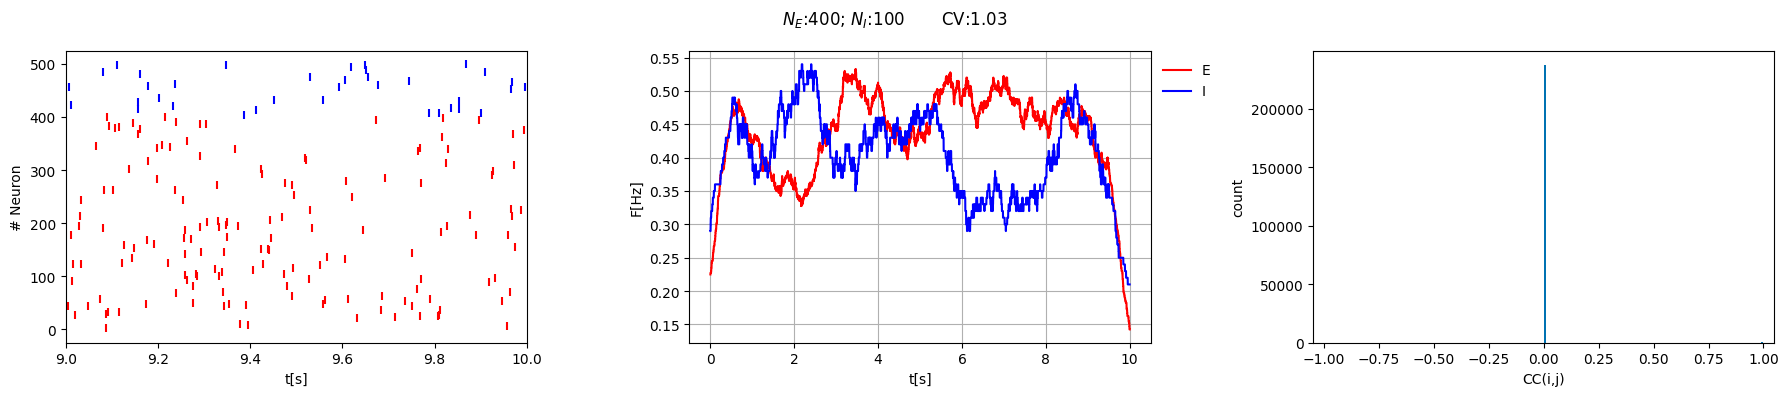

In [42]:
def update_networkplot(n_E, n_I, fac_EE, fac_EI, fac_IE, fac_II, title):
    fig, ax = plt.subplots(1,3,figsize=(18, 4))
    print('Simulation is running')
    spike_tot, spikes_E, spikes_I, rate_e, rate_i = run_connected_network(n_E, n_I, fac_EE, fac_EI, fac_IE, fac_II)
    ax[0].scatter(spikes_E.t,spikes_E.i, color = 'r', marker = '|')
    ax[0].scatter(spikes_I.t,spikes_I.i+n_E, color = 'b', marker = '|')
    ax[0].set_xlim(9,10)
    ax[0].set_xlabel('t[s]')
    ax[0].set_ylabel('# Neuron')
    ax[1].plot(rate_e.t/second, rate_e.smooth_rate(window = 'flat',width = 1*second)/Hz, color = 'r', label = 'E')
    ax[1].plot(rate_i.t/second, rate_i.smooth_rate(window = 'flat',width = 1*second)/Hz, color = 'b', label = 'I')
    ax[1].grid(True)
    ax[1].legend(bbox_to_anchor = (1.0,1.0), loc = 'upper left', frameon = False)
    ax[1].set_xlabel('t[s]')
    ax[1].set_ylabel('F[Hz]')
    ax[2].hist(CC_calc(spike_tot, 10000, n_E+n_I), bins = 100)
    ax[2].set_xlim(-1.05,1.05)
    ax[2].set_xlabel('CC(i,j)')
    ax[2].set_ylabel('count')
    fig.suptitle(title+'       CV:'+str(round(CV_calc(spike_tot),2)))
    fig.tight_layout()
    plt.show()

# Button to run the simulation
run_button = widgets.Button(description="Run simulation")


ne_input = widgets.IntText(
    value=400,
    description=' N_E:',
    step=1
)

ni_input = widgets.IntText(
    value=100,
    description=' N_I:',
    step=1
)

# Function to handle button click
def on_button_click(b):
    update_networkplot(ne_input.value, ni_input.value, 1, 1,4,4, '$N_E$:'+str(ne_input.value)+'; $N_I$:'+str(ni_input.value))

output = widgets.Output()

run_button.on_click(on_button_click)

# Display the input and button
display(widgets.VBox([ne_input,ni_input, run_button, output]))

The higher the number of neurons, the higher the activity in the network due to synaptic connection driving network activity. The higher the amount of excitatory neurons, the higher the degree of synchonicity. As explained before a high degree of synchronous activity is computationally unfavourable. In the followingm we explore how the relative strength of excitatory and inhibitory synapses influence the network dynamics



# 4. Synaptic Excitatory-Inhibitory balance and network synchronization

Excitatory-Inhibitory balance is a concept which exists on multiple dimensions. Broad or global EI balance generally refers to rates. It means that the Excitatory rate and the Inhibitory rate develop in a similar manner. When inhibition rises, the excitatory rate increases as well.

On the other hand tight EI balance restricts the congruent behaviour to shorter timescales. Most often tight EI balance refers to the instantaneous rate measured over a few miliseconds and can even refer to synchronous spiking patterns (allwoing for small lags).

Local EI balance often refers to synaptic EI balance. Here we consider the input received by a neuron. A neuron which receives similarly strong excitatory and inhibtiory input would be considered to be locally/synaptically balanced.

Synchronization is tightly related to the local EI balance. Here we define local EI balance as the differences in strength between the excitatory and inhibitory synapses. In the following, you can set this explicitly in the network:  $g_{EE}$ sets the multiplicative factor for the EE connections, $g_{EI}$ sets the factor E to I connections and so on.

In [9]:

ee_input = widgets.FloatText(
    value=1,
    description=' $g_{EE}$:',
    step=.01
)

ei_input = widgets.FloatText(
    value=1,
    description=' $g_{EI}$:',
    step=.01
)

ie_input = widgets.FloatText(
    value=4,
    description=' $g_{IE}$:',
    step=.01
)

ii_input = widgets.FloatText(
    value=4,
    description=' $g_{II}$:',
    step=.01
)

# Function to handle button click
def on_button_click(b):
    update_networkplot(N_E, N_I, ee_input.value, ei_input.value,ie_input.value,ii_input.value, '$g_{max}^{EE}$:'+str(ee_input.value)+'; $g_{max}^{EI}$:'+str(ei_input.value)+'; $g_{max}^{IE}$:'+str(ie_input.value)+'; $g_{max}^{EI}$:'+str(ii_input.value))

output = widgets.Output()

run_button.on_click(on_button_click)

# Display the input and button
display(widgets.VBox([ee_input,ei_input, ie_input, ii_input, run_button, output]))

What we can notice is that inhibition and specifically the strength of the IE synapse is a crucial parameter for the network behaviour. When the IE synapse is weak the network synchronises. Strong inhibtiory input to the excitatory population decorrelates the network activity.



# 5. Inhibitory plasticity can decorrelate recurrent networks

**5.1. Reference**

<!-- The following results and insights about the function of inhibitory plasticity have been introduced by *Vogels et al. (2011)* in their paper *Inhibitory plasticity balances excitation and inhibition in sensory processing and Hebbian assemblies*. -->

**5.2. Inhibitory plasticity rule**
The plasticity rule we will be using follows a symmteric LTP dominated STDP kernel. Pre-post pairing with short inter spike intervall leads to LTP. However, every presynaptic spike also leads to the depression of the synapse. Mathematically it is described by:

\begin{align}
\delta w = \eta \cdot pre \cdot post - \alpha \cdot pre
\end{align}


We first implement a synapse and the learning rule to visualise the STDP kernel. You can test how the kernel changes by changing the time constant $\tau_{STDP}$ and presynaptic depression factor $\alpha$.

INFO: C compiler: x86_64-linux-gnu-gcc -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -g -fwrapv -O2 -fPIC

creating /tmp/brian_flag_test_gmrw0r97/tmp
creating /tmp/brian_flag_test_gmrw0r97/tmp/brian_flag_test_gmrw0r97
INFO: compile options: '-c'
extra options: '-w'
INFO: x86_64-linux-gnu-gcc: /tmp/brian_flag_test_gmrw0r97/flag_test.cpp
INFO: C compiler: x86_64-linux-gnu-gcc -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -g -fwrapv -O2 -fPIC

creating /tmp/brian_flag_test_9mdav727/tmp
creating /tmp/brian_flag_test_9mdav727/tmp/brian_flag_test_9mdav727
INFO: compile options: '-c'
extra options: '-O3'
INFO: x86_64-linux-gnu-gcc: /tmp/brian_flag_test_9mdav727/flag_test.cpp
INFO: C compiler: x86_64-linux-gnu-gcc -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -

INFO: C compiler: x86_64-linux-gnu-gcc -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -g -fwrapv -O2 -fPIC

INFO: compile options: '-I/usr/include -I/home/patricia/.local/lib/python3.10/site-packages/numpy/core/include -I/home/patricia/.local/lib/python3.10/site-packages/brian2/synapses -I/usr/include/python3.10 -c'
extra options: '-w -O3 -ffast-math -fno-finite-math-only -march=native -std=c++11'
INFO: x86_64-linux-gnu-gcc: /home/patricia/.cython/brian_extensions/_cython_magic_95d269e39b4e73e3f9ac7f43edf458bd.cpp
INFO: x86_64-linux-gnu-g++ -shared -Wl,-O1 -Wl,-Bsymbolic-functions -Wl,-Bsymbolic-functions -g -fwrapv -O2 /home/patricia/.cython/brian_extensions/home/patricia/.cython/brian_extensions/_cython_magic_95d269e39b4e73e3f9ac7f43edf458bd.o -L/usr/lib -L/usr/lib/x86_64-linux-gnu -Wl,--enable-new-dtags,-R/usr/lib -o /home/patricia/.cython/brian_extensions/_cython_magic_95d269e39b4e73e3f9ac7f43edf458bd.cpy

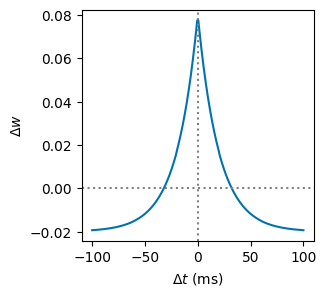

In [4]:
#equations and updates for the plasticity rule
#the differential equations calculate "eligibility traces" which set the width of the kernel
syn_eq = '''
    w:1
    dapre/dt = -apre/tau_stdp : 1 (event-driven)
    dapost/dt = -apost/tau_stdp : 1 (event-driven)
'''

onpre = '''
    apre += 1
    w = clip(w+ (apost - alpha)*eta,0,wmax) '''

onpost = '''
    apost += 1
    w = clip(w+apre * eta, 0, wmax)'''


N = 200


eta = 0.1

wmax = 2
tmax = 100*ms

def run_sim(tau, alpha_v):
    start_scope()
    tau_stdp = tau * ms
    alpha = alpha_v
    G = NeuronGroup(N, 'tspike:second', threshold='t>tspike', refractory=200*ms)
    H = NeuronGroup(N, 'tspike:second', threshold='t>tspike', refractory=200*ms)
    G.tspike = 'i*tmax/(N-1)'
    H.tspike = '(N-1-i)*tmax/(N-1)'
    
    S = Synapses(G, H,syn_eq,on_pre = onpre, on_post= onpost)
    S.connect(j='i')
    S.w = 1

    run(tmax+1*ms)
    fig, ax = plt.subplots(1,1, figsize = (3,3))
    ax.plot((H.tspike-G.tspike)/ms, S.w -1)
    ax.set_xlabel(r'$\Delta t$ (ms)')
    ax.set_ylabel(r'$\Delta w$')
    ax.axhline(0, ls=':', c='grey')
    ax.axvline(0, ls=':', c='grey')
    plt.show()



tau_input = widgets.IntText(
    value=20,
    description=' τ (STDP):',
    step=1
)

alpha_input = widgets.FloatText(
    value=0.2,
    description=' α (LTD):',
    step=.01
)

# Button to run the simulation
run_button = widgets.Button(description="Calculate STDP kernel")

# Function to handle button click
def on_button_click(b):
    run_sim(tau_input.value, alpha_input.value)

output = widgets.Output()

run_button.on_click(on_button_click)

# Display the input and button
display(widgets.VBox([tau_input,alpha_input, run_button, output]))

**5.3. De-synchronising recurrent ativity**

![title](plastic_network.png)

We have previously seen that week inhibition leads to highly synchronous activity in the network. Our initial network has very weak inhibitory synapses. Therefore, initial network activity is highly synchronous. Plastic inhibitory synapses can help to establish the AI regime in a network. As shown in the diagram, only the EI synapses are plastic. They learn using the formerly defined plasticity rule. 

In [11]:
#redefining our network
#all of this needs to be trials with different parameters and longer run times.
#providing a stabilised network and only inidcating the overall runtime this needs might be the way to go for this.
palette = plt.rcParams['axes.prop_cycle'].by_key()['color']  


N_E = 4000
N_I = 1000

E_l = -79 * mV
E_e = 0 * mV
E_i = -80 * mV
v_spike = -49 * mV
C_m = 180*pF
g_l = 18 * nS


tau_noise = C_m/g_l
I_sigma = 400 * pA  #0.4 Hz background activity for both populations roughly
I_mu = 0 * pA

tau_syn_e = 5 * ms
tau_syn_i = 10 * ms

tau_stdp = 20 * ms
alpha = 3*Hz*tau_stdp*2  #this discounting factor is defined relative to the target rate
eta = 0.01 # small learning rate can help achieve more stable bevahiour with smoother bevioural changes

wmax = 100

#indexes for the engram which is inserted later on
engram_1 = np.arange(1800,2000,1,dtype = int)
engram_2 = np.arange(1975,2175, dtype = int)


p_conn = 0.02 #connection propability

LIF_eq = '''dv/dt = (g_l * (E_l - v)- g_e * (v - E_e)-g_i * (v-E_i)+I_eta + I_e)/C_m  : volt (unless refractory)
                dI_eta/dt = 1/ tau_noise * (I_mu - I_eta) + I_sigma*xi*tau_noise**-0.5 : ampere
                dg_e/dt = -g_e/tau_syn_e : siemens
                dg_i/dt = -g_i/tau_syn_i : siemens
                I_e: ampere'''

syn_eq_plastic = '''
    w:1
    dapre/dt = -apre/tau_stdp : 1 (event-driven)
    dapost/dt = -apost/tau_stdp : 1 (event-driven)
'''
syn_eq_nonplastic = '''w:1'''

on_pre_IE = ''' g_i += w * nS
                apre +=1
                w = clip(w+ (apost - alpha)*eta,0,wmax)'''
on_post_IE = ''' apost +=1
                w = clip(w+apre*eta,0,wmax)'''

on_pre_E = '''g_e += w * 3 * nS '''
on_pre_I = '''g_i += w * 30 * nS '''


start_scope() #to keep the networks clean when running the same entities multiple times
seed(5) #to ensure similar results each run
#We have one big population which we subdivide into one excitatory and one inhibitory
N_Pop = NeuronGroup(N_E+N_I,  LIF_eq, threshold = 'v > v_spike', reset = 'v = E_l', refractory = 3 * ms, method = 'euler')
N_Pop.v = (np.random.rand(N_E+N_I)*15-79) * mV #staring vs are distributed around resting potention +-15mV


#connect them
EE = Synapses(N_Pop[:N_E], N_Pop, syn_eq_nonplastic,on_pre = on_pre_E)
EE.connect(p = p_conn)
EE.w = 1

IE = Synapses(N_Pop[N_E:], N_Pop[:N_E], syn_eq_plastic, on_pre = on_pre_IE, on_post = on_post_IE)
IE.connect(p = p_conn)
IE.w = 0.0001#w_syn * 4/np.log(N_I*p_conn)

II = Synapses(N_Pop[N_E:], N_Pop[N_E:], syn_eq_nonplastic,on_pre = on_pre_I)
II.connect(p = p_conn)
II.w = 1

#to record activity
s_E1 = SpikeMonitor(N_Pop[engram_1])
s_E2 = SpikeMonitor(N_Pop[engram_2])
s_Ec = SpikeMonitor(N_Pop[np.arange(engram_1.shape[0], dtype = 'int')])
s_I = SpikeMonitor(N_Pop[N_E:])


#records the rates right away
r_E1 = PopulationRateMonitor(N_Pop[engram_1])
r_E2 = PopulationRateMonitor(N_Pop[engram_2])
r_Ec = PopulationRateMonitor(N_Pop[np.arange(engram_1.shape[0], dtype = 'int')])

r_I = PopulationRateMonitor(N_Pop[N_E:])

#record the IE weights
ws = StateMonitor(IE, ['w'], record = np.arange(10),dt = 1 * ms) #we only record 10 synapses to save on memory

IE_to_store = np.full((N_I,N_E), np.nan)
IE_to_store[IE.i[:],IE.j[:]] = IE.w[:]
np.save('stored_networks/IE_initial_weights.npy', IE_to_store)
store(filename ='stored_networks/initial_network' )

In [11]:
#we first run the network for 1s without plasticity
eta = 0
run(1 * second, report = 'text') #run the network for a full second, you can delete the status report by omitting the second argument in the function


#run the network with plasticity for 9 s
eta = 0.01
run(9 * second,report = 'text')

building '_cython_magic_68279624e64208750cf6191c6ccd92d4' extension
INFO: C compiler: x86_64-linux-gnu-gcc -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -g -fwrapv -O2 -fPIC

INFO: compile options: '-I/usr/include -I/home/patricia/.local/lib/python3.10/site-packages/brian2/synapses -I/home/patricia/.local/lib/python3.10/site-packages/numpy/core/include -I/home/patricia/.local/lib/python3.10/site-packages/brian2/synapses -I/usr/include/python3.10 -c'
extra options: '-w -O3 -ffast-math -fno-finite-math-only -march=native -std=c++11'
INFO: x86_64-linux-gnu-gcc: /home/patricia/.cython/brian_extensions/_cython_magic_68279624e64208750cf6191c6ccd92d4.cpp
INFO: x86_64-linux-gnu-g++ -shared -Wl,-O1 -Wl,-Bsymbolic-functions -Wl,-Bsymbolic-functions -g -fwrapv -O2 /home/patricia/.cython/brian_extensions/home/patricia/.cython/brian_extensions/_cython_magic_68279624e64208750cf6191c6ccd92d4.o -L/usr/lib -L/usr/lib/x86_64-

building '_cython_magic_2984c8b3a27631514b7e94e0fea53458' extension
INFO: C compiler: x86_64-linux-gnu-gcc -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -g -fwrapv -O2 -fPIC

INFO: compile options: '-I/usr/include -I/home/patricia/.local/lib/python3.10/site-packages/brian2/synapses -I/home/patricia/.local/lib/python3.10/site-packages/numpy/core/include -I/home/patricia/.local/lib/python3.10/site-packages/brian2/synapses -I/usr/include/python3.10 -c'
extra options: '-w -O3 -ffast-math -fno-finite-math-only -march=native -std=c++11'
INFO: x86_64-linux-gnu-gcc: /home/patricia/.cython/brian_extensions/_cython_magic_2984c8b3a27631514b7e94e0fea53458.cpp
INFO: x86_64-linux-gnu-g++ -shared -Wl,-O1 -Wl,-Bsymbolic-functions -Wl,-Bsymbolic-functions -g -fwrapv -O2 /home/patricia/.cython/brian_extensions/home/patricia/.cython/brian_extensions/_cython_magic_2984c8b3a27631514b7e94e0fea53458.o -L/usr/lib -L/usr/lib/x86_64-

building '_cython_magic_2bccb54a9c5b92516b2064595e718658' extension
INFO: C compiler: x86_64-linux-gnu-gcc -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -g -fwrapv -O2 -fPIC

INFO: compile options: '-I/usr/include -I/home/patricia/.local/lib/python3.10/site-packages/brian2/synapses -I/home/patricia/.local/lib/python3.10/site-packages/numpy/core/include -I/home/patricia/.local/lib/python3.10/site-packages/brian2/synapses -I/usr/include/python3.10 -c'
extra options: '-w -O3 -ffast-math -fno-finite-math-only -march=native -std=c++11'
INFO: x86_64-linux-gnu-gcc: /home/patricia/.cython/brian_extensions/_cython_magic_2bccb54a9c5b92516b2064595e718658.cpp
INFO: x86_64-linux-gnu-g++ -shared -Wl,-O1 -Wl,-Bsymbolic-functions -Wl,-Bsymbolic-functions -g -fwrapv -O2 /home/patricia/.cython/brian_extensions/home/patricia/.cython/brian_extensions/_cython_magic_2bccb54a9c5b92516b2064595e718658.o -L/usr/lib -L/usr/lib/x86_64-

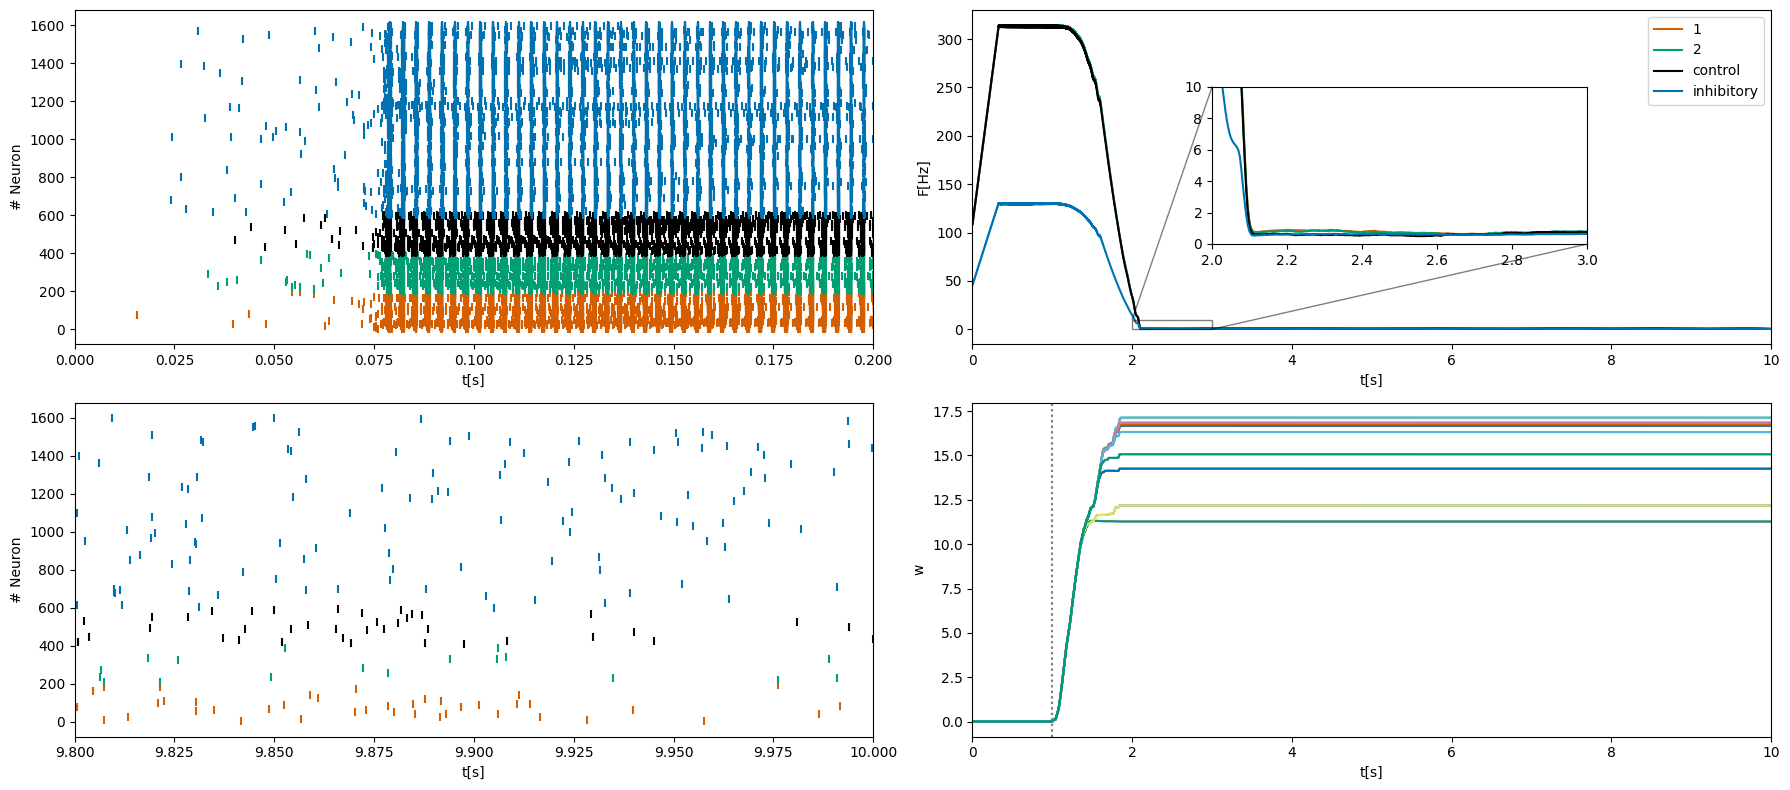

In [28]:
#visualise the simulation results
fig, ax = plt.subplots(2,2,figsize=(18, 8))
ax[0,0].scatter(s_E1.t,s_E1.i, color = palette[2], marker = '|')
ax[0,0].scatter(s_E2.t,s_E2.i+(engram_1.shape[0]), color = palette[1], marker = '|')
ax[0,0].scatter(s_Ec.t,s_Ec.i+(engram_1.shape[0])+(engram_2.shape[0]), color = 'k', marker = '|')
ax[0,0].scatter(s_I.t, s_I.i+(engram_1.shape[0])+(engram_2.shape[0])+engram_1.shape[0], color = palette[0], marker = '|')
ax[0,0].set_xlabel('t[s]')
ax[0,0].set_ylabel('# Neuron')
ax[1,0].scatter(s_E1.t,s_E1.i, color = palette[2], marker = '|')
ax[1,0].scatter(s_E2.t,s_E2.i+(engram_1.shape[0]), color = palette[1], marker = '|')
ax[1,0].scatter(s_Ec.t,s_Ec.i+(engram_1.shape[0])+(engram_2.shape[0]), color = 'k', marker = '|')
ax[1,0].scatter(s_I.t, s_I.i+(engram_1.shape[0])+(engram_2.shape[0])+engram_1.shape[0], color = palette[0], marker = '|')

ax[1,0].set_xlabel('t[s]')
ax[1,0].set_ylabel('# Neuron')
ax[0,1].plot(r_E1.t/second, r_E1.smooth_rate(window = 'flat',width = 0.5*second)/Hz, color = palette[2], label = '1')
ax[0,1].plot(r_E2.t/second, r_E2.smooth_rate(window = 'flat',width = 0.5*second)/Hz, color = palette[1], label = '2')
ax[0,1].plot(r_Ec.t/second, r_Ec.smooth_rate(window = 'flat',width = 0.5*second)/Hz, color = 'k', label = 'control')
ax[0,1].plot(r_I.t/second, r_I.smooth_rate(window = 'flat', width = 0.5*second)/Hz, color = palette[0], label = 'inhibitory')
ax[0,1].legend()
ax[0,1].set_xlabel('t[s]')
ax[0,1].set_ylabel('F[Hz]')

for i in arange(10):
    ax[1,1].plot(ws.t/second, ws.w[i])
ax[1,1].axvline(1, ls=':', c='grey')
ax[1,1].set_xlabel('t[s]')
ax[1,1].set_ylabel('w')

ax[0,0].set_xlim(0,.2)
ax[1,0].set_xlim(9.8,10)
ax[0,1].set_xlim(0,10)
ax[1,1].set_xlim(0,10)
x1, x2, y1, y2 = 2, 3, 0, 10  # subregion of the rate plot
axins = ax[0,1].inset_axes(
    [.3, .3, .47, .47],
    xlim=(x1, x2), ylim=(y1, y2))
axins.plot(r_E1.t/second, r_E1.smooth_rate(window = 'flat',width = 0.5*second)/Hz, color = palette[2], label = '1')
axins.plot(r_E2.t/second, r_E2.smooth_rate(window = 'flat',width = 0.5*second)/Hz, color = palette[1], label = '2')
axins.plot(r_Ec.t/second, r_Ec.smooth_rate(window = 'flat',width = 0.5*second)/Hz, color = 'k', label = 'control')
axins.plot(r_I.t/second, r_I.smooth_rate(window = 'flat', width = 0.5*second)/Hz, color = palette[0], label = 'inhibitory')

ax[0,1].indicate_inset_zoom(axins, edgecolor="black")
ax[0,1].set_xlabel('t[s]')
ax[0,1].set_ylabel('F[Hz]')

fig.tight_layout()
plt.show()


**5.4 Stabilising inserted Memory engrams via inhibitory plasticity**

Now that the network is in a favourable activity regime, we want to use the network to store memory patterns. Therefore, we insert two (overlapping) memory engrams in the EE weights of our network. Therefore, the total strength of the excitatory synapses increase. 

![title](insert_engram_network.png)

*Note: Can you think of a way to learn such assemblies or memory engrams in a recurrent network?*


Our two cell assemblies are formed between Neurons 1500-1800 and 1700-2000:

In [29]:
W_before = np.full((N_E + N_I,N_E + N_I), np.nan)
W_before[EE.i[:],EE.j[:]] = EE.w[:]
W_before[II.i[:]+N_E,II.j[:]+N_E] = II.w[:] * -1
W_before[IE.i[:]+N_E,IE.j[:]] = IE.w[:] * -1

factor = 5 # increase of the engrams weights

EE.w[engram_1, engram_1] = factor
EE.w[engram_2, engram_2] = factor

W_after = np.full((N_E + N_I,N_E + N_I), np.nan)
W_after[EE.i[:],EE.j[:]] = EE.w[:]
W_after[II.i[:]+N_E,II.j[:]+N_E] = II.w[:] * -1
W_after[IE.i[:]+N_E,IE.j[:]] = IE.w[:] * -1

store(filename = 'stored_networks/inserted_engrams_EI_network')

Unfortunately, our weight matrix is too sparse to show any significant difference in the printed matrixes alone. Howver, we can check that the matrix insertion worked by calculating, the minimum, maximum and mean of the full weight matrix. After a successfull engram insertion these statistics should have changed (except the minimum).

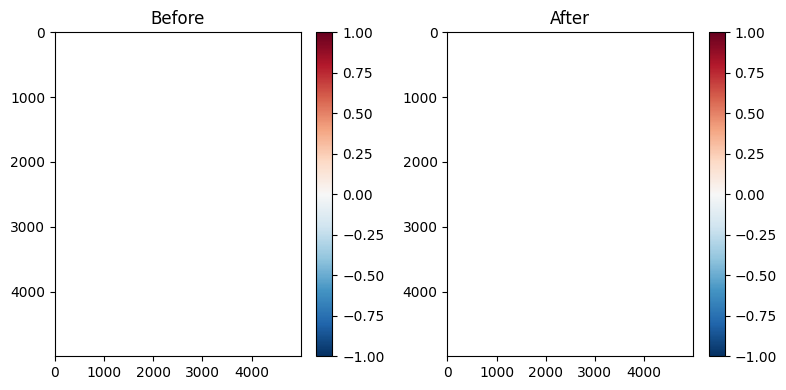

Before:
-0.8607976432251042
-32.51386200849779
1.0
After:
-0.8479706834620079
-32.51386200849779
5.0


In [30]:
fig, ax = subplots(1,2,figsize = (8,4))
hm = ax[0].imshow(W_before, cmap = 'RdBu_r', vmin = -1, vmax= 1, aspect = 'auto')
ax[0].set_title('Before')
fig.colorbar(hm, ax=ax[0])
hm2 = ax[1].imshow(W_after, cmap = 'RdBu_r', vmin = -1, vmax = 1, aspect = 'auto')
fig.colorbar(hm2, ax=ax[1])
ax[1].set_title('After')
fig.tight_layout()
plt.show()

print('Before:')
print(np.nanmean(W_before))
print(np.nanmin(W_before))
print(np.nanmax(W_before))

print('After:')
print(np.nanmean(W_after))
print(np.nanmin(W_after))
print(np.nanmax(W_after))

In [31]:
#run the network without plasticity to see the shift in activity
eta = 0
run(1 * second, report = 'text')

#let the plasticity stabilise the network

eta = 0.01
run(9 * second,report = 'text')

Starting simulation at t=10. s for a duration of 1. s
1. s (100%) simulated in 2s
Starting simulation at t=11. s for a duration of 9. s
3.9019 s (43%) simulated in 10s, estimated 13s remaining.
8.0801 s (89%) simulated in 20s, estimated 2s remaining.
9. s (100%) simulated in 22s


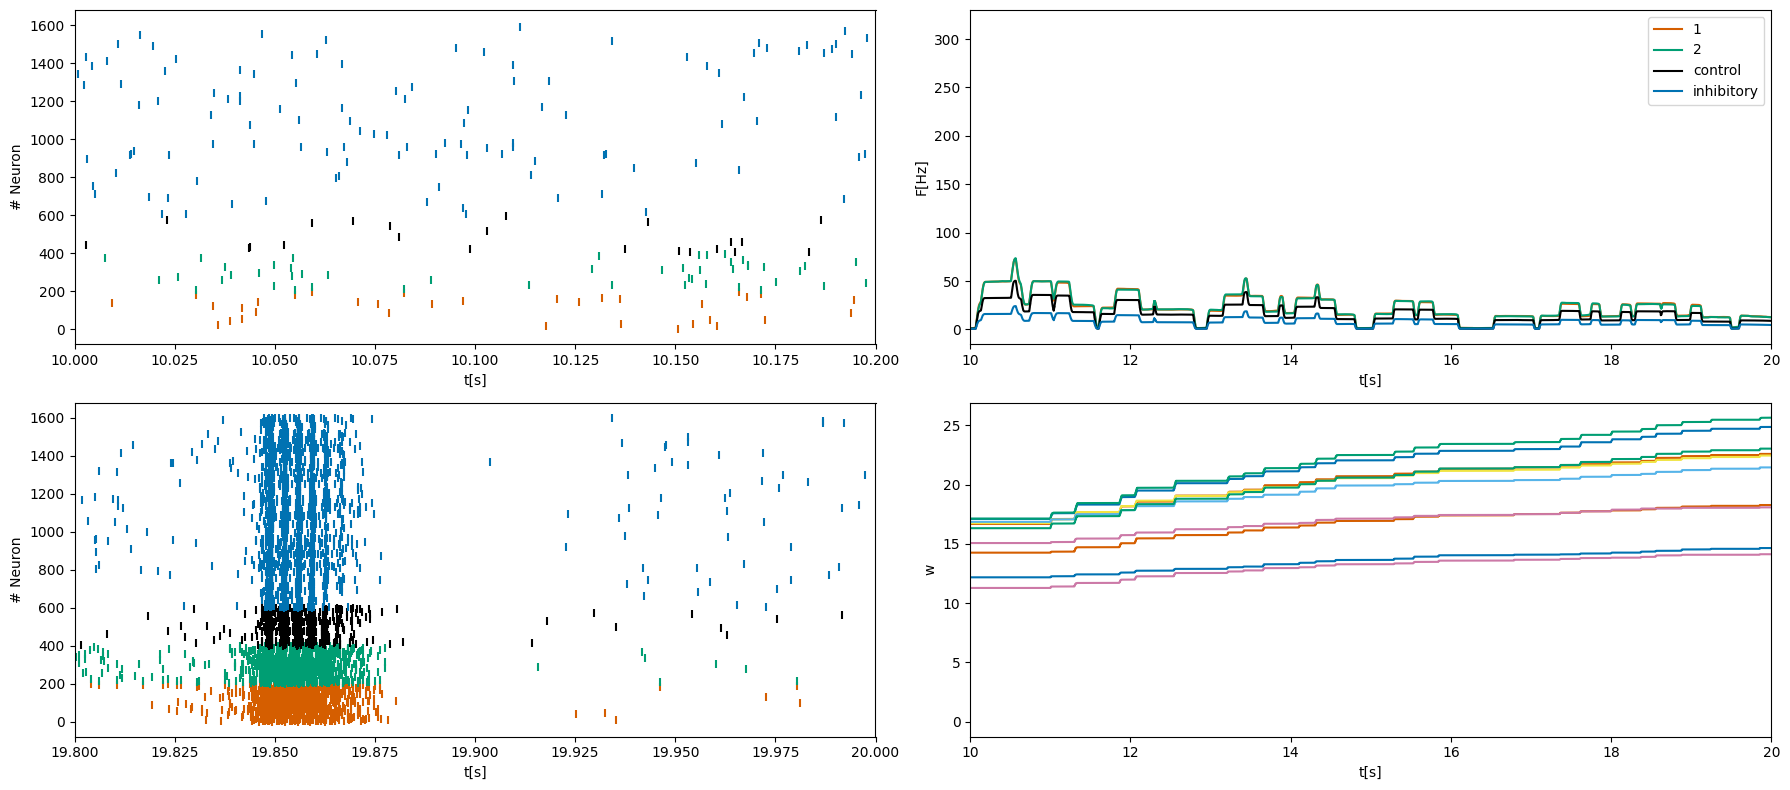

In [32]:
#visualise the simulation results
fig, ax = plt.subplots(2,2,figsize=(18, 8))
ax[0,0].scatter(s_E1.t,s_E1.i, color = palette[2], marker = '|')
ax[0,0].scatter(s_E2.t,s_E2.i+(engram_1.shape[0]), color = palette[1], marker = '|')
ax[0,0].scatter(s_Ec.t,s_Ec.i+(engram_1.shape[0])+(engram_2.shape[0]), color = 'k', marker = '|')
ax[0,0].scatter(s_I.t, s_I.i+(engram_1.shape[0])+(engram_2.shape[0])+engram_1.shape[0], color = palette[0], marker = '|')
ax[0,0].set_xlabel('t[s]')
ax[0,0].set_ylabel('# Neuron')
ax[1,0].scatter(s_E1.t,s_E1.i, color = palette[2], marker = '|')
ax[1,0].scatter(s_E2.t,s_E2.i+(engram_1.shape[0]), color = palette[1], marker = '|')
ax[1,0].scatter(s_Ec.t,s_Ec.i+(engram_1.shape[0])+(engram_2.shape[0]), color = 'k', marker = '|')
ax[1,0].scatter(s_I.t, s_I.i+(engram_1.shape[0])+(engram_2.shape[0])+engram_1.shape[0], color = palette[0], marker = '|')

ax[1,0].set_xlabel('t[s]')
ax[1,0].set_ylabel('# Neuron')
ax[0,1].plot(r_E1.t/second, r_E1.smooth_rate(window = 'flat',width = 0.5*second)/Hz, color = palette[2], label = '1')
ax[0,1].plot(r_E2.t/second, r_E2.smooth_rate(window = 'flat',width = 0.5*second)/Hz, color = palette[1], label = '2')
ax[0,1].plot(r_Ec.t/second, r_Ec.smooth_rate(window = 'flat',width = 0.5*second)/Hz, color = 'k', label = 'control')
ax[0,1].plot(r_I.t/second, r_I.smooth_rate(window = 'flat', width = 0.5*second)/Hz, color = palette[0], label = 'inhibitory')
ax[0,1].legend()
ax[0,1].set_xlabel('t[s]')
ax[0,1].set_ylabel('F[Hz]')

for i in arange(10):
    ax[1,1].plot(ws.t/second, ws.w[i])
ax[1,1].axvline(1, ls=':', c='grey')
ax[1,1].set_xlabel('t[s]')
ax[1,1].set_ylabel('w')

ax[0,0].set_xlim(10,10.2)
ax[1,0].set_xlim(19.8,20)
ax[0,1].set_xlim(10,20)
ax[1,1].set_xlim(10,20)

fig.tight_layout()
plt.show()


In [33]:
########################################################
# DO NOT RUN THIS CELL DURING THE (in-person) TUTORIAL #
########################################################

#run(280 * second, report = 'text')

#IE_to_store = np.full((N_I,N_E), np.nan)
#IE_to_store[IE.i[:],IE.j[:]] = IE.w[:]

#np.save('stored_networks/IE_trained_weights.npy', IE_to_store)

#store(filename = 'stored_networks/trained_network')

Starting simulation at t=20. s for a duration of 280. s
4.0658 s (1%) simulated in 10s, estimated 11m 19s remaining.
7.6585 s (2%) simulated in 20s, estimated 11m 51s remaining.
11.8025 s (4%) simulated in 30s, estimated 11m 22s remaining.
15.9161 s (5%) simulated in 40s, estimated 11m 4s remaining.
20.2181 s (7%) simulated in 50s, estimated 10m 42s remaining.
24.4431 s (8%) simulated in 1m 0s, estimated 10m 27s remaining.
28.3276 s (10%) simulated in 1m 10s, estimated 10m 22s remaining.
32.3893 s (11%) simulated in 1m 20s, estimated 10m 12s remaining.
36.6 s (13%) simulated in 1m 30s, estimated 9m 59s remaining.
40.7933 s (14%) simulated in 1m 40s, estimated 9m 46s remaining.
45.0118 s (16%) simulated in 1m 50s, estimated 9m 34s remaining.
49.3307 s (17%) simulated in 2m 0s, estimated 9m 21s remaining.
53.6975 s (19%) simulated in 2m 10s, estimated 9m 8s remaining.
57.7919 s (20%) simulated in 2m 20s, estimated 8m 58s remaining.
61.9438 s (22%) simulated in 2m 30s, estimated 8m 48s re

AttributeError: module 'brian2.numpy_' has no attribute 'safe'

Due to the runtime for simulating the network for 280s, we will restore the network to a previously safed version. This is the network state after running it for 280s. 

If you enough time left, you can uncomment all code above and comment out the following cell with the *restore()* command. Execution time of the 280s simulation is roughly 10-15min. 

In [ ]:
restore(filename = 'stored_networks/trained_network')

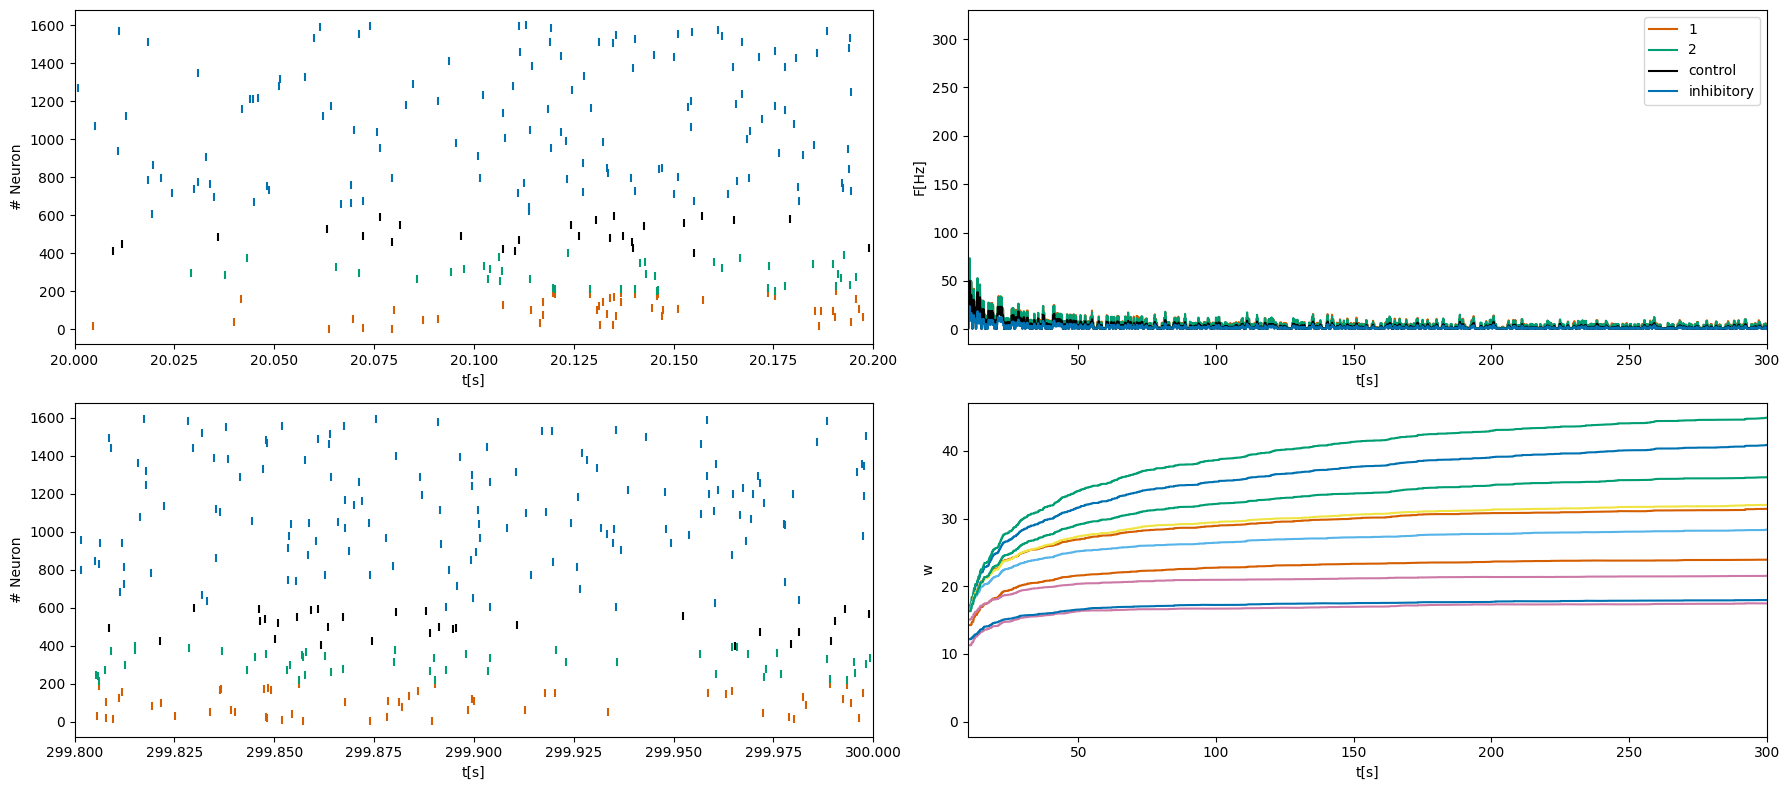

In [35]:
#visualise the simulation results
fig, ax = plt.subplots(2,2,figsize=(18, 8))
ax[0,0].scatter(s_E1.t,s_E1.i, color = palette[2], marker = '|')
ax[0,0].scatter(s_E2.t,s_E2.i+(engram_1.shape[0]), color = palette[1], marker = '|')
ax[0,0].scatter(s_Ec.t,s_Ec.i+(engram_1.shape[0])+(engram_2.shape[0]), color = 'k', marker = '|')
ax[0,0].scatter(s_I.t, s_I.i+(engram_1.shape[0])+(engram_2.shape[0])+engram_1.shape[0], color = palette[0], marker = '|')
ax[0,0].set_xlabel('t[s]')
ax[0,0].set_ylabel('# Neuron')
ax[1,0].scatter(s_E1.t,s_E1.i, color = palette[2], marker = '|')
ax[1,0].scatter(s_E2.t,s_E2.i+(engram_1.shape[0]), color = palette[1], marker = '|')
ax[1,0].scatter(s_Ec.t,s_Ec.i+(engram_1.shape[0])+(engram_2.shape[0]), color = 'k', marker = '|')
ax[1,0].scatter(s_I.t, s_I.i+(engram_1.shape[0])+(engram_2.shape[0])+engram_1.shape[0], color = palette[0], marker = '|')

ax[1,0].set_xlabel('t[s]')
ax[1,0].set_ylabel('# Neuron')
ax[0,1].plot(r_E1.t/second, r_E1.smooth_rate(window = 'flat',width = 0.5*second)/Hz, color = palette[2], label = '1')
ax[0,1].plot(r_E2.t/second, r_E2.smooth_rate(window = 'flat',width = 0.5*second)/Hz, color = palette[1], label = '2')
ax[0,1].plot(r_Ec.t/second, r_Ec.smooth_rate(window = 'flat',width = 0.5*second)/Hz, color = 'k', label = 'control')
ax[0,1].plot(r_I.t/second, r_I.smooth_rate(window = 'flat', width = 0.5*second)/Hz, color = palette[0], label = 'inhibitory')
ax[0,1].legend()
ax[0,1].set_xlabel('t[s]')
ax[0,1].set_ylabel('F[Hz]')

for i in arange(10):
    ax[1,1].plot(ws.t/second, ws.w[i])
ax[1,1].axvline(1, ls=':', c='grey')
ax[1,1].set_xlabel('t[s]')
ax[1,1].set_ylabel('w')

ax[0,0].set_xlim(20,20.2)
ax[1,0].set_xlim(299.8,300)
ax[0,1].set_xlim(10,300)
ax[1,1].set_xlim(10,300)

fig.tight_layout()
plt.show()


The events which still need to stabilise are the spontaneous self-activations of the engram which surge through the full network. These drive short periods of synchronous activity. We run the network for another 200s so that it can settle into a state without these engram reverberations (spontaneous reactivations).

Tip: If you want to have a closer look at the preceeding spiking dynamics of spontaneous reactivation, you can find them at strong increases in the rate of the control group. Set the spike raster on top to these time windows to have a closer look at the events.

In [27]:
#####################################
#DO NOT RUN THIS CELL DURING THE (in-person) TUTORIAL
#####################################


#load the pretrained network
#restore(filename = 'stored_network/pre_trained_EI_network')

#run(1200 * second, report = 'text')

#IE_to_store = np.full((N_I,N_E), np.nan)
#IE_to_store[IE.i[:],IE.j[:]] = IE.w[:]

#np.save('stored_networks/IE_fully_trained_weights.npy', IE_to_store)

#store(filename = 'stored_networks/fully_trained_network')

*Note:* Due to the long run time of the cell above (~30 min), we will load pretrained weights. You can train the network yourself, if you want to play around with the training time.


**5.5 Engram reactivation**

![title](reactivation_network.png)

After stabilising the network activity via inhibitory plasticity, the network still encodes the engrams in its excitatory weights. Spontaneous activity in the network does not show a footprint of the memories anymore. But we can try to reactivate them with a partial stimulus. The stimulus in form of an external constant current is delivered to a subgroup of the engram neurons. 

In [22]:
restore(filename = 'stored_networks/fully_trained_network')

size_stim = 25 #neuron, maximally 200 (engram_1.shape[0])

N_Pop.I_e[engram_1[:size_stime]] = 30 * pA  #a subpopulation of the 1st engram is receiving an additional current (constant)
eta = 0
r_stimmed = PopulationRateMonitor(N_Pop[engram_1[:size_stim]])
s_stimmed = SpikeMonitor(N_Pop[engram_1[:size_stim]])

run(1 * second, report = 'text')


building '_cython_magic_4defcd37b2d82fb838335d2ec221555b' extension
INFO: C compiler: x86_64-linux-gnu-gcc -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -g -fwrapv -O2 -fPIC

INFO: compile options: '-I/usr/include -I/home/patricia/.local/lib/python3.10/site-packages/numpy/core/include -I/home/patricia/.local/lib/python3.10/site-packages/brian2/synapses -I/usr/include/python3.10 -c'
extra options: '-w -O3 -ffast-math -fno-finite-math-only -march=native -std=c++11'
INFO: x86_64-linux-gnu-gcc: /home/patricia/.cython/brian_extensions/_cython_magic_4defcd37b2d82fb838335d2ec221555b.cpp
INFO: x86_64-linux-gnu-g++ -shared -Wl,-O1 -Wl,-Bsymbolic-functions -Wl,-Bsymbolic-functions -g -fwrapv -O2 /home/patricia/.cython/brian_extensions/home/patricia/.cython/brian_extensions/_cython_magic_4defcd37b2d82fb838335d2ec221555b.o -L/usr/lib -L/usr/lib/x86_64-linux-gnu -Wl,--enable-new-dtags,-R/usr/lib -o /home/patricia/.cython

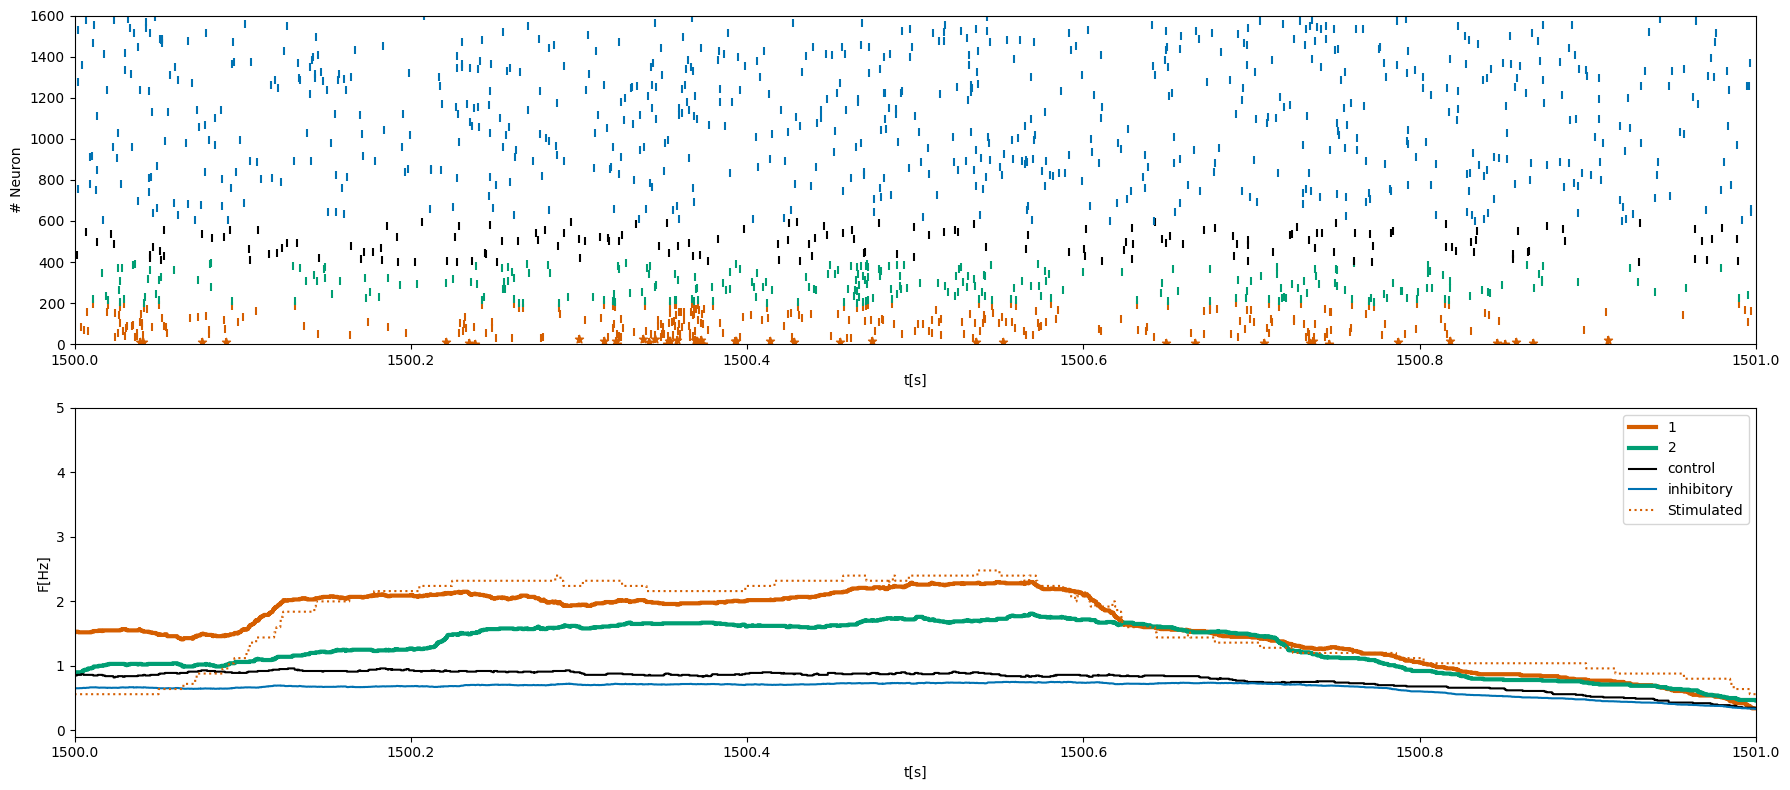

In [26]:
fig, ax = plt.subplots(2,1,figsize=(18, 8))
ax[0].scatter(s_E1.t,s_E1.i, color = palette[2], marker = '|')
ax[0].scatter(s_stimmed.t,s_stimmed.i, color = palette[2], marker = '*')
ax[0].scatter(s_E2.t,s_E2.i+(engram_1.shape[0]), color = palette[1], marker = '|')
ax[0].scatter(s_Ec.t,s_Ec.i+(engram_1.shape[0])+(engram_2.shape[0]), color = 'k', marker = '|')
ax[0].scatter(s_I.t, s_I.i+(engram_1.shape[0])+(engram_2.shape[0])+engram_1.shape[0], color = palette[0], marker = '|')
ax[0].set_xlabel('t[s]')
ax[0].set_ylabel('# Neuron')

ax[1].plot(r_E1.t/second, r_E1.smooth_rate(window = 'flat',width = 0.5*second)/Hz, color = palette[2], label = '1', linewidth = 3)
ax[1].plot(r_E2.t/second, r_E2.smooth_rate(window = 'flat',width = 0.5*second)/Hz, color = palette[1], label = '2', linewidth = 3)
ax[1].plot(r_Ec.t/second, r_Ec.smooth_rate(window = 'flat',width = 0.5*second)/Hz, color = 'k', label = 'control')
ax[1].plot(r_I.t/second, r_I.smooth_rate(window = 'flat', width = 0.5*second)/Hz, color = palette[0], label = 'inhibitory')
ax[1].plot(r_stimmed.t/second, r_stimmed.smooth_rate(window = 'flat',width = 0.5*second)/Hz, color = palette[2], linestyle = ':', label = 'Stimulated')
ax[1].legend()
ax[1].set_xlabel('t[s]')
ax[1].set_ylabel('F[Hz]')


ax[0].set_xlim(1500,1501)
ax[1].set_xlim(1500,1501)
ax[1].set_ylim(-0.1, 5)
ax[0].set_ylim(0,1600)

fig.tight_layout()
plt.show()